In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# load all metadata

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marcos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/marcos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Cargamos los datos
data = pd.read_csv('justice.csv')
x_train = data['facts']
y_train1 = data['first_party_winner']
y_train2 = data['issue_area']

In [3]:
#Elimina signos de puntuacion y todo a minusculas
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(x_train))

In [4]:
#Eliminamos las stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

In [5]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [6]:
#Lematizamos
def lemmatization(texts):
    texts_out = []
    for text in texts:
        lemText = []
        for sent in text:
            stemmed = ps.stem(sent)
            lemText.append(lem.lemmatize(stemmed))
        texts_out.append(lemText)
    return texts_out

data_lemmatized = lemmatization(data_words_nostops)

In [7]:
#Topic modeling
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
#lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, update_every=1, chunksize=100, passes=20, alpha='auto',per_word_topics=True)
#print(f"TOPICOS --> {lda.print_topics()}")

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=100, random_state=100, passes=50, eval_every=None)
count = 0
topics=[]
for i in lda_model.print_topics():
    print("Topic:", count, i)
    topics.append(i)
    count += 1

Topic: 0 (8, '0.030*"court" + 0.027*"commerc" + 0.026*"commiss" + 0.023*"act" + 0.022*"state" + 0.015*"interst" + 0.014*"regul" + 0.014*"carrier" + 0.014*"rule" + 0.013*"appeal"')
Topic: 1 (35, '0.055*"court" + 0.027*"judg" + 0.019*"district" + 0.018*"appoint" + 0.017*"appeal" + 0.015*"presid" + 0.015*"feder" + 0.014*"govern" + 0.012*"unit" + 0.010*"case"')
Topic: 2 (47, '0.017*"law" + 0.017*"court" + 0.016*"first" + 0.013*"person" + 0.012*"public" + 0.012*"hotel" + 0.011*"member" + 0.011*"american" + 0.010*"activ" + 0.010*"banc"')
Topic: 3 (67, '0.187*"new" + 0.117*"citi" + 0.103*"york" + 0.029*"second" + 0.026*"jackson" + 0.016*"state" + 0.013*"law" + 0.011*"court" + 0.010*"judgment" + 0.009*"two"')
Topic: 4 (36, '0.070*"intern" + 0.060*"ir" + 0.049*"tax" + 0.041*"servic" + 0.035*"report" + 0.029*"revenu" + 0.022*"amount" + 0.019*"rate" + 0.017*"taxpay" + 0.017*"year"')
Topic: 5 (78, '0.068*"vehicl" + 0.045*"truck" + 0.044*"stop" + 0.038*"marijuana" + 0.038*"driver" + 0.036*"drive" +

In [8]:
#Hay que cambiar el n_topics por el numero de topics del LDA
n_topics = 100
vectorized = []
count = 0
#Recorrer los documentos
for i in lda_model[corpus]:
    #Inicializar index como lista de ceros, de longitud 'n_topics'
    index = [0]*n_topics
    #Recorrer cada palabra de cada documento
    for n in i:
        #En index[8] guardamos la informacion del tópico 8
        index[n[0]] = n[1]
    vectorized.append(index)
vectorized = pd.DataFrame(vectorized)
#Filas documentos (facts)
#Columnas topics
print(vectorized)

            0    1         2    3         4         5    6         7    8   \
0     0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
1     0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.072343  0.0   
2     0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
3     0.000000  0.0  0.000000  0.0  0.000000  0.061300  0.0  0.000000  0.0   
4     0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
...        ...  ...       ...  ...       ...       ...  ...       ...  ...   
3298  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
3299  0.000000  0.0  0.000000  0.0  0.000000  0.550637  0.0  0.000000  0.0   
3300  0.000000  0.0  0.173232  0.0  0.111085  0.000000  0.0  0.000000  0.0   
3301  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
3302  0.075766  0.0  0.000000  0.0  0.066312  0.000000  0.0  0.000000  0.0   

       9   ...        90   91   92       93   94   95   96     

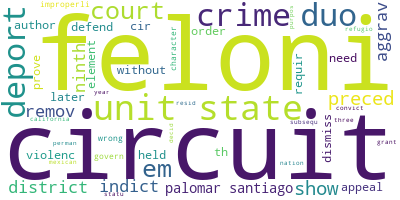

In [9]:
#Word cloud de documento 3298
from wordcloud import WordCloud

nDocumento = 3298
string = ','.join(data_lemmatized[nDocumento])

wordcloud = WordCloud(background_color="white", max_words=len(data_lemmatized[0]), contour_width=3, contour_color='steelblue')
wordcloud.generate(string)
wordcloud.to_image()

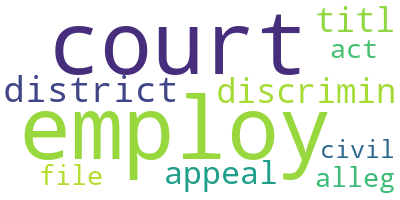

In [10]:
# WordCloud del topico 15
l = topics[15][1]

l = l.split("+")

lista =[]
for x in l:
    numero, palabra = x.split('*')
    palabra = palabra.split('"')[1]
    i=0
    while i < float(numero)*100:
        lista.append(palabra)
        i+=1
lista = ','.join(lista)

wordcloud.generate(lista)
wordcloud.to_image()


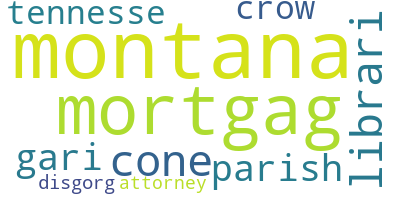

In [11]:
# WordCloud del topico 16
l = topics[16][1]

l = l.split("+")

lista =[]
for x in l:
    numero, palabra = x.split('*')
    palabra = palabra.split('"')[1]
    i=0
    while i < float(numero)*100:
        lista.append(palabra)
        i+=1
lista = ','.join(lista)

wordcloud.generate(lista)
wordcloud.to_image()


In [12]:
#Comparar dimensiones antes y después de hacer el pca
from sklearn.decomposition import  PCA

print("Before:", vectorized.shape)
#pca = PCA(n_components='mle', svd_solver='full')
pca = PCA(n_components=2)
pca.fit(vectorized)
labels_PCA= pca.transform(vectorized)
print("After:", labels_PCA.shape)

Before: (3303, 100)
After: (3303, 2)


In [13]:
#Distancia euclídea
import math
import numpy as np
def getDist(clust1, clust2):
    dist = 0
    #Sumatorio de distancias euclideas
    for i in range(len(clust1)):
        #Calcular la distancia euclídea de cada i
        dist += math.sqrt((clust1[i] - clust2[i])**2)
    return dist

In [14]:
#Generar la matriz con las distancias entre cada cluster
def getDistances(clusters):
    distances = []
    for clust1 in range(len(clusters)):
        #Convertir a numpy
        dist_clust1 = [np.NAN] * (clust1+1)
        for clust2 in [t for t in range(len(clusters)) if t > clust1]:
            dist_clust1.append(getDist(clusters[clust1], clusters[clust2]))
        distances.append(np.array(dist_clust1))
    distances = np.array(distances)
    return distances

In [15]:
#Agrupa la fila y columna de la matriz de distancias, con la menor distancia
def hierarchical_clustering(data):
    distances = getDistances(data)
    #Número de iteración, la distancia y los clusters
    k_clusters = [0,0,[[i] for i in range(len(data))]]

    tree = [[],[]]
    tree_aux = [i for i in range(len(data))]
    list_of_clusters = []
    list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])
    it = 0
    n_inst = len(data)

    print("Starting")
    #Recorrer hasta que sólo queda un cluster
    while len(distances) > 1:
        ind1,ind2 = np.unravel_index(np.nanargmin(distances), distances.shape)
        #Coger la distancia mínima
        min_dist = np.nanmin(distances)
        #Eliminar y agrupar las columnas y filas que contengan esa distancia mínima
        delete = max(ind1,ind2)
        replace = min(ind1,ind2)
        #Calcular la distancia máxima
        for i in [t for t in range(len(distances)) if t != ind1 and t != ind2]:
            distance = np.nanmax([distances[ind1][i],distances[ind2][i],distances[i][ind1],distances[i][ind2]])
            if replace < i:
                distances[replace][i] = distance
            else:
                distances[i][replace] = distance
        #Eliminar fila y columna
        distances = np.delete(distances, delete,1)
        distances = np.delete(distances, delete,0)
        #Añadir los valores para el dendograma 
        tree[0].append([tree_aux[replace],tree_aux[delete]])
        tree[1].append(min_dist)
        tree_aux[replace] = it + n_inst
        tree_aux.remove(tree_aux[delete])
        #Número de iteración
        k_clusters[0] = it
        #La distancia mínima
        k_clusters[1] = min_dist
        #Sustituir por el sustituto + el borrado
        k_clusters[2][replace] = k_clusters[2][replace]+k_clusters[2][delete]
        #Borrar el borrado
        k_clusters[2].remove(k_clusters[2][delete])
        it += 1

        list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])

    print("End")
    return list_of_clusters,tree
list_of_clusters, tree = hierarchical_clustering(labels_PCA)

Starting
End


In [115]:
#Dado un número de clusters, devuelve a que cluster pertenece cada instancia, 
#distancia y en cada cluster qué instancias hay
def get_nClusters(list_clusters, k):
    n_inst = len(list_clusters[0][2])
    for clusters in list_clusters:
        if len(clusters[2]) == k:
            kClusters = [0] * n_inst
            dist = clusters[1]
            i = 0
            for clust in clusters[2]:
                for c in clust:
                    kClusters[c] = i
                i += 1
            return kClusters,dist,clusters[2]
    return [], 0


k_labels, dist, k_clusters = get_nClusters(list_of_clusters,2)

In [34]:
#Dado una distancia máxima, devuelve a que cluster pertenece cada instancia, 
#el número de clusters y en cada cluster qué instancias hay
def get_distClusters(list_clusters, d):
    n_inst = len(list_clusters[0][2])
    clusters_aux = list_clusters[0]
    for clusters in list_clusters:
        if clusters[1] > d:
            distClusters = [0] * n_inst
            nClusters = len(clusters)
            i = 0
            for clust in clusters_aux[2]:
                for c in clust:
                    distClusters[c] = i
                i += 1
            return distClusters, nClusters, clusters[2]
        clusters_aux = clusters
    return [], 0


dist_labels, nClusters, dist_clusters = get_distClusters(list_of_clusters,1)

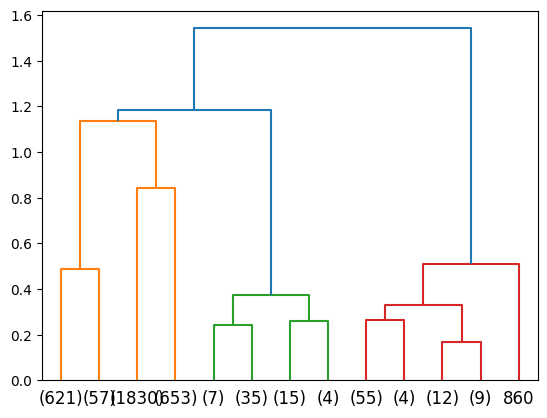

In [105]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(tree, labels ,mode , p, threshold):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(len(tree[0]))
    n_samples = len(labels)
    for i, merge in enumerate(tree[0]):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [tree[0], tree[1], counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode=mode, p=p , color_threshold=threshold)


#mode : "lastp" p numero de nodos hoja, "level" p profundidad del dendograma.
#threshold : la linea que separa los clusters.
plot_dendrogram(tree,labels_PCA,mode ="level", p=3, threshold=dist+0.01)

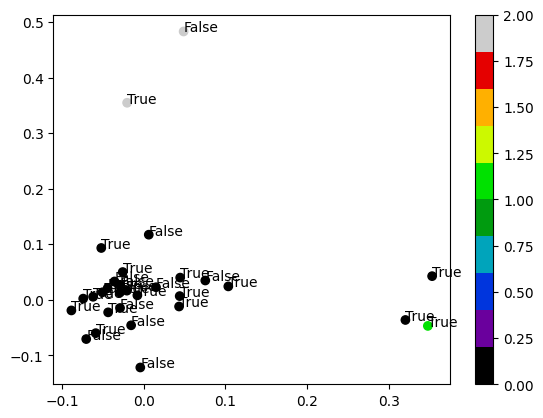

In [41]:
import matplotlib.pyplot as plt
samples = 30

# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(labels_PCA[:samples,0],labels_PCA[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=k_labels[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(labels_PCA[i,0],labels_PCA[i,1], y_train1[i])

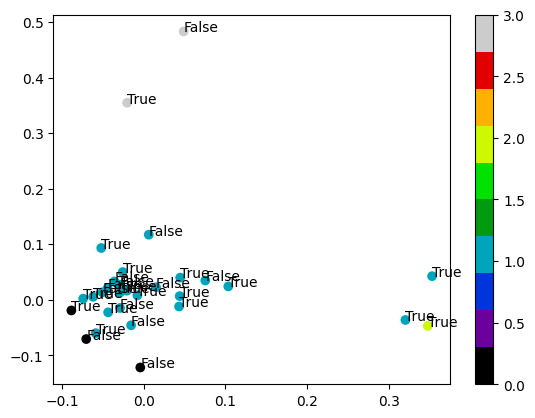

In [42]:
import matplotlib.pyplot as plt
samples = 30

# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(labels_PCA[:samples,0],labels_PCA[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=dist_labels[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(labels_PCA[i,0],labels_PCA[i,1], y_train1[i])

In [21]:
def get_Centers(clusters, data):
    centers = []
    for x in range((max(clusters) + 1)):
        centers.append([])

    n_inst = [0] * (max(clusters) + 1)
    for i in range(len(clusters)):
        for i2 in range(len(data[0])):
            if len(centers[clusters[i]]) <= i2:
                centers[clusters[i]].append(data[i][i2])
            else:
                centers[clusters[i]][i2]+=data[i][i2]
        n_inst[clusters[i]] += 1

    for i in range((max(clusters) + 1)):
        for i2 in range(len(data[0])):
            centers[i][i2] = centers[i][i2] / n_inst[i]

    return centers

For n_clusters = 2 The average silhouette_score is : 0.6309069294459887
For n_clusters = 3 The average silhouette_score is : 0.5799246825242466
For n_clusters = 4 The average silhouette_score is : 0.20146854324315308
For n_clusters = 5 The average silhouette_score is : 0.2594803938962073
For n_clusters = 6 The average silhouette_score is : 0.2779338761171228
For n_clusters = 7 The average silhouette_score is : 0.266864559804274
For n_clusters = 8 The average silhouette_score is : 0.28751702668685536


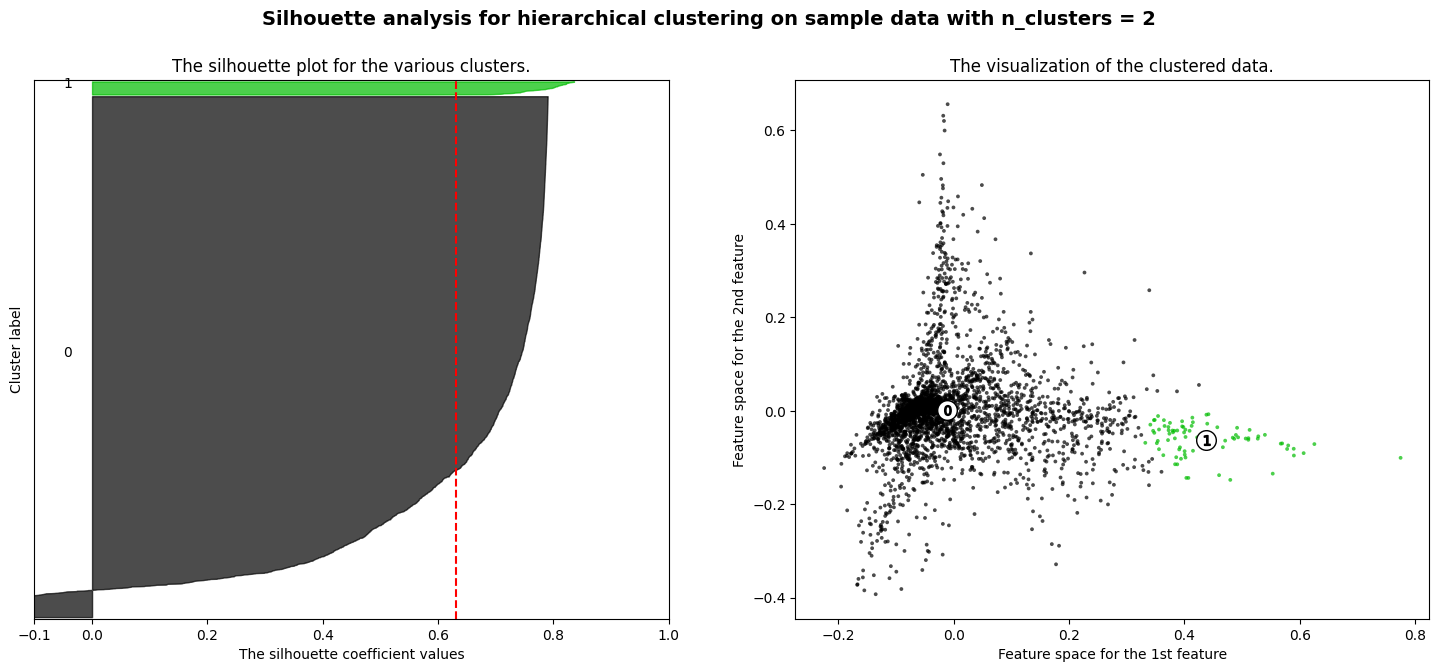

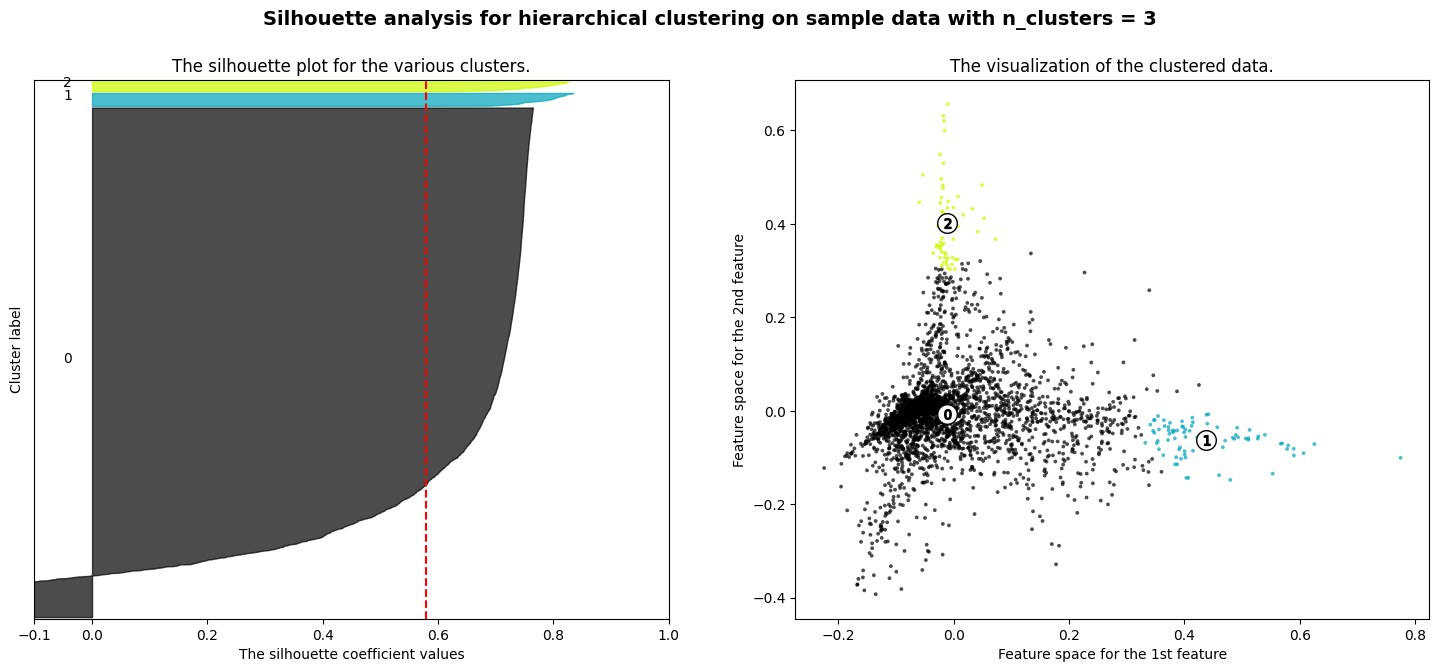

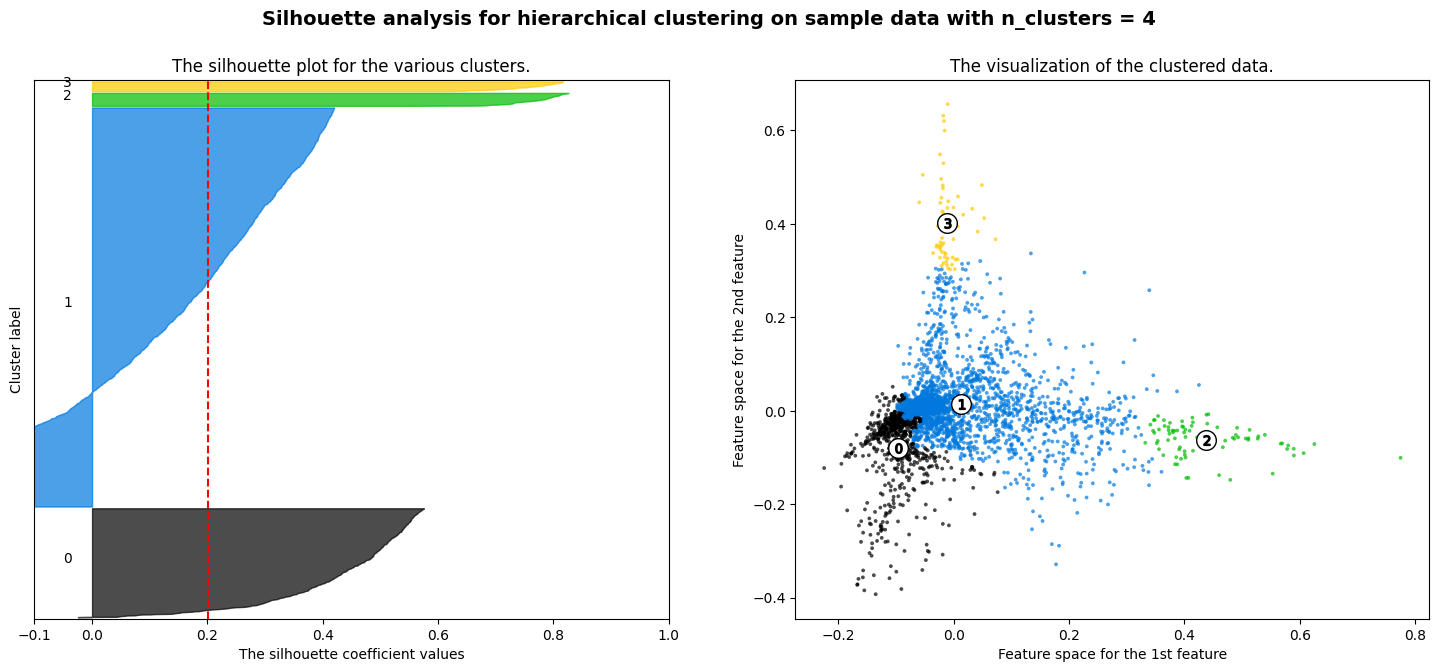

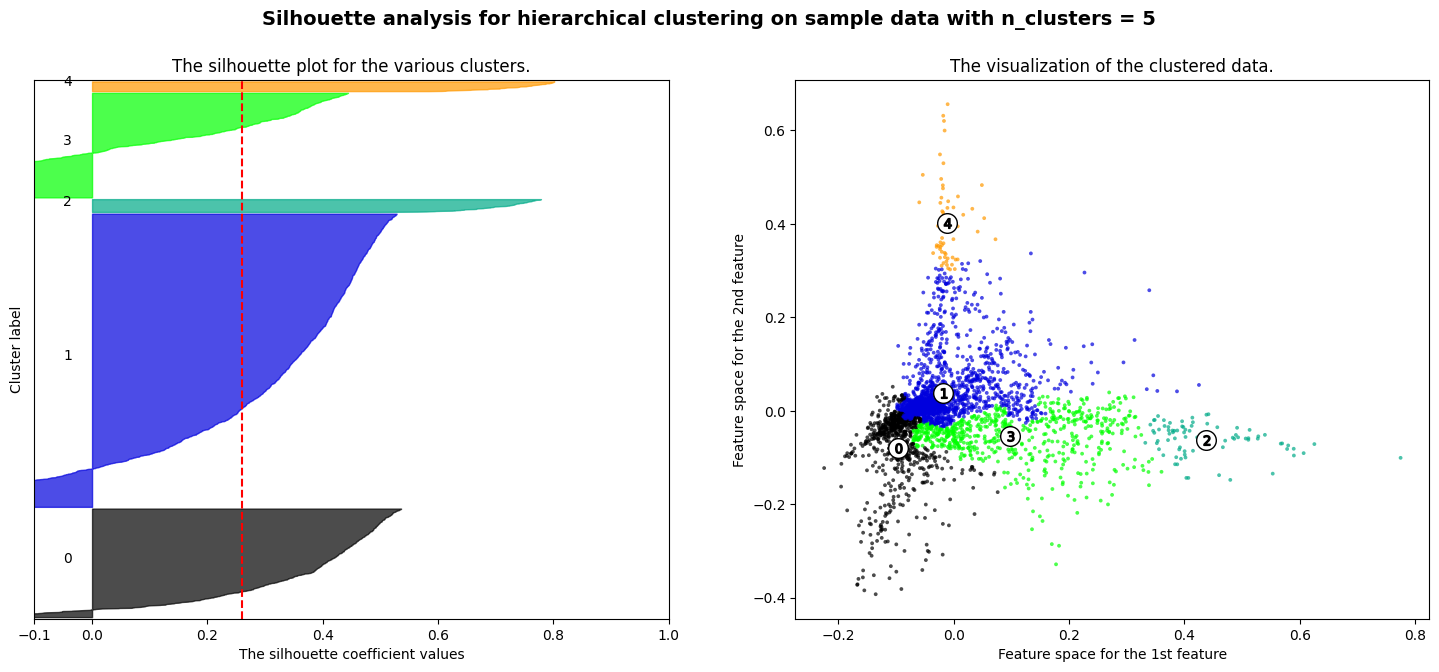

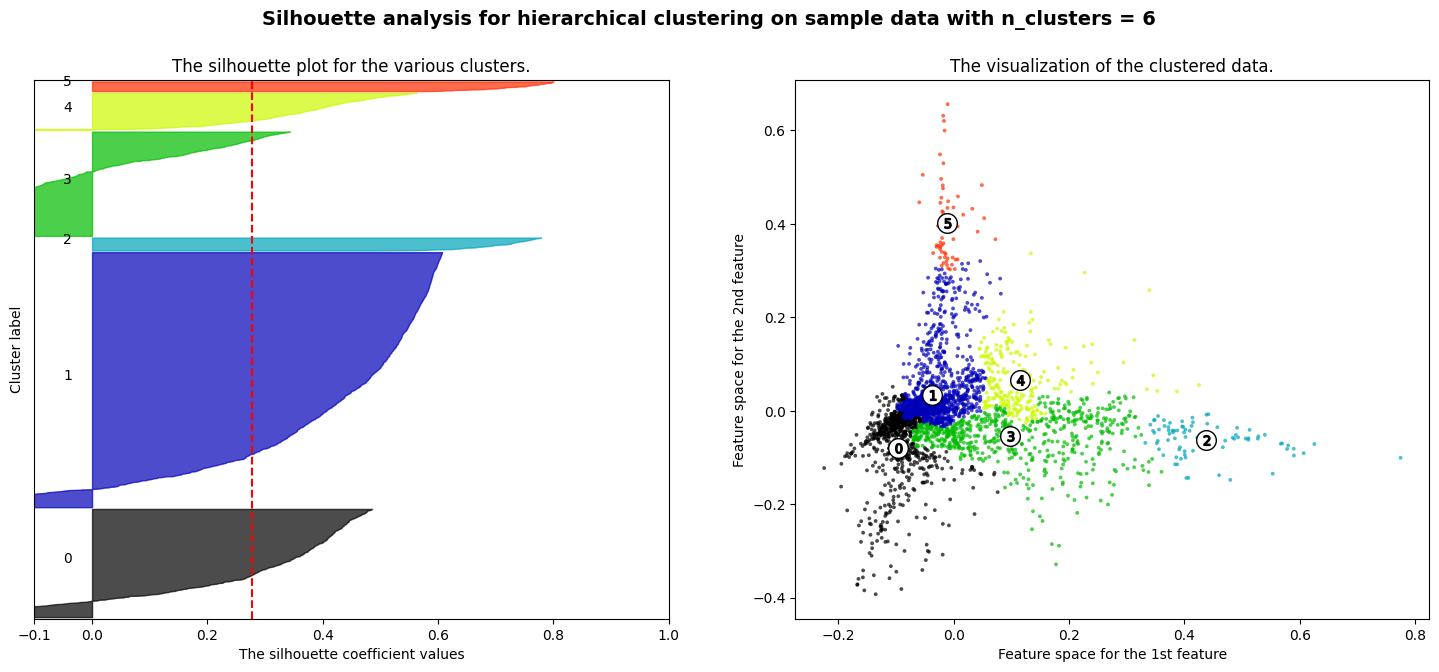

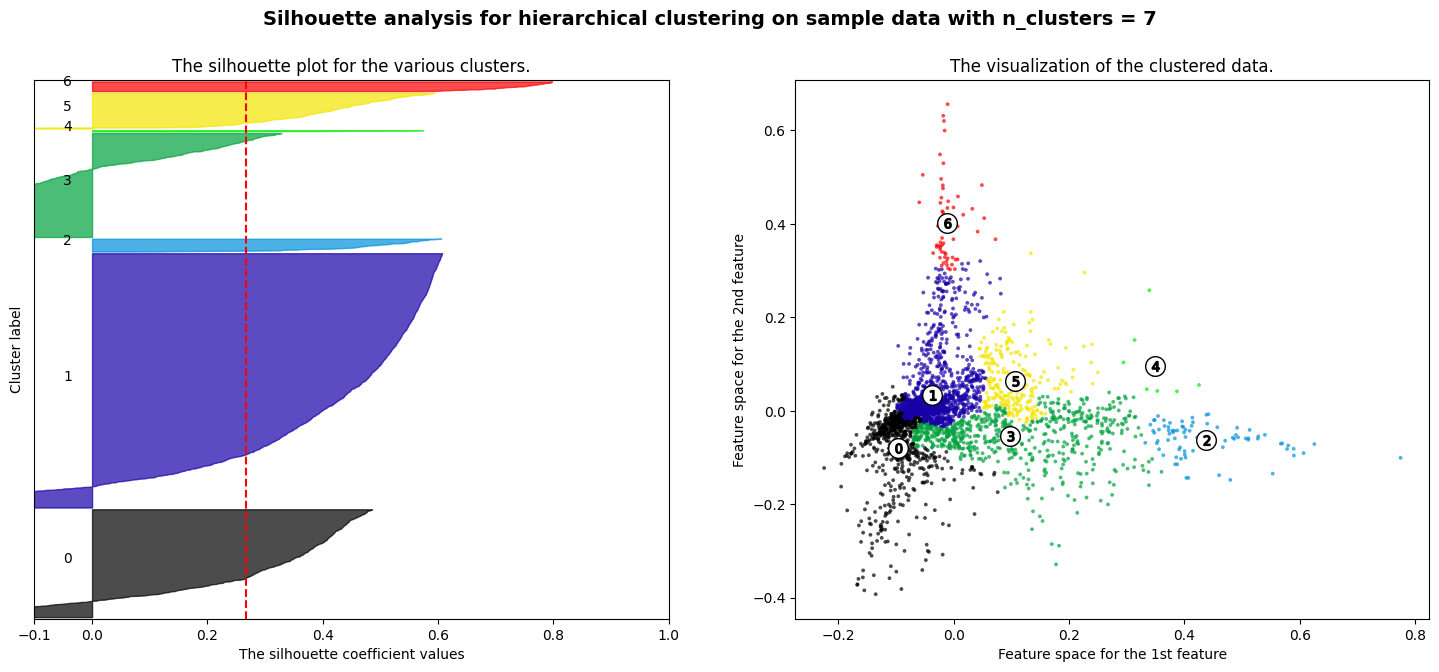

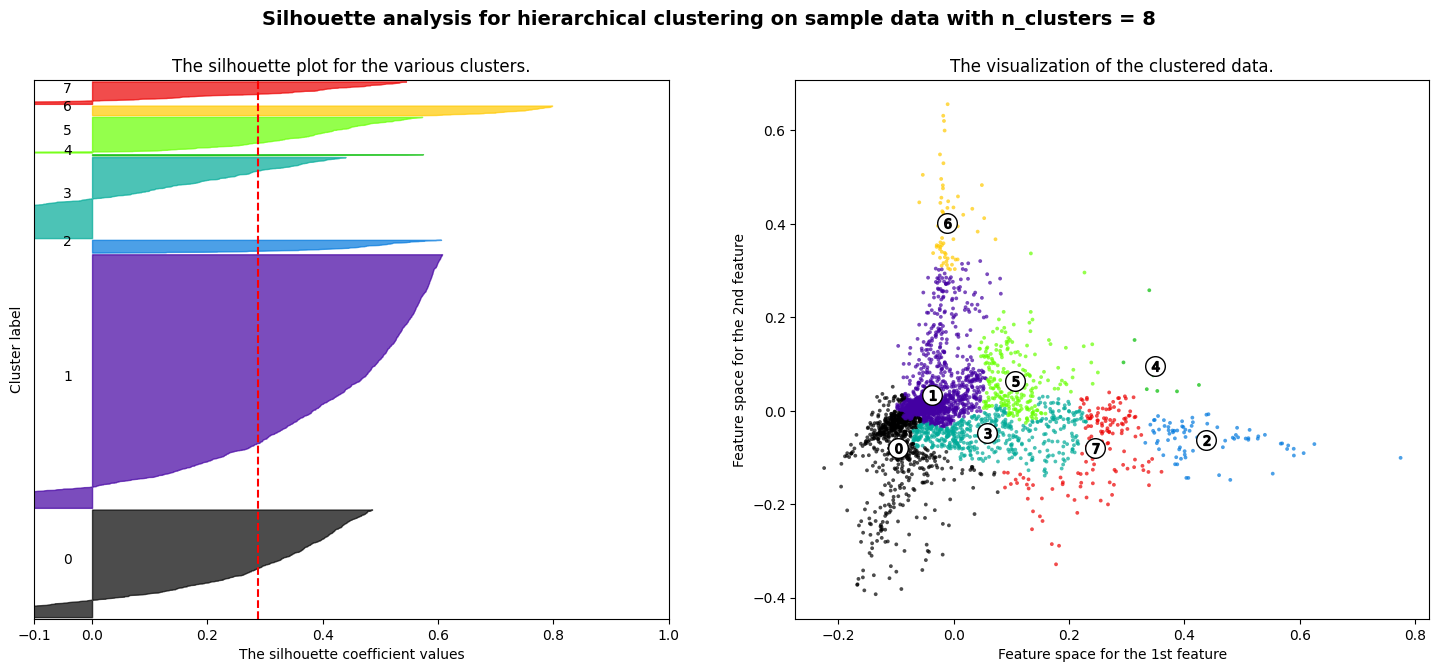

In [22]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = list(range(2,9,1))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(labels_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster_labels_og, dist = get_nClusters(list_of_clusters,n_clusters)
    cluster_labels = np.array(cluster_labels_og)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(labels_PCA, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(labels_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        labels_PCA[:, 0], labels_PCA[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = get_Centers(cluster_labels_og, labels_PCA)
    centers = np.array(centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for hierarchical clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [87]:
#Calcular centroides
def centroides(clusters,data):
    centers = []
    for x in range((len(clusters))):
        centers.append([])

    n_inst = [0] * (len(clusters))
    for i in range(len(clusters)):
        for y in clusters[i]:
            for i2 in range(len(data[0])):
                if len(centers[i]) <= i2:
                    centers[i].append(data[y][i2])
                else:
                    centers[i][i2]+=data[y][i2]
            n_inst[i] += 1

    for i in range((len(clusters))):
        for i2 in range(len(data[0])):
            centers[i][i2] = centers[i][i2] / n_inst[i]

    return centers

In [81]:
#Añadir una nueva instancia AÑADIR LA INSTANCIA QUE SE QUIERA, EJEMPLO 3
instancia = x_train[3]
#Eliminar carácteres extraños
ins_words = list(sent_to_words([instancia]))
#Eliminar las stop words
ins_words_nostops = remove_stopwords(ins_words)
#Lematizar
ins_lemmatized = lemmatization(ins_words_nostops)
#Vectorizar
id2word = corpora.Dictionary(ins_lemmatized)
texts = ins_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
lda_model[corpus]
print(lda_model[corpus][0])


[(2, 0.08823409), (18, 0.12728871), (34, 0.099958956), (42, 0.10106477), (48, 0.16317818), (71, 0.090526454), (93, 0.22237982), (98, 0.081079885)]


In [83]:
vectorized = []
count = 0
#Recorrer los documentos
for i in lda_model[corpus]:
    #Inicializar index como lista de ceros, de longitud 'n_topics'
    index = [0]*n_topics
    #Recorrer cada palabra de cada documento
    for n in i:
        #En index[8] guardamos la informacion del tópico 8
        index[n[0]] = n[1]
    vectorized.append(index)
vectorized = pd.DataFrame(vectorized)
#Filas documentos (facts)
#Columnas topics
print(vectorized)

   0   1         2   3   4   5   6   7   8   9   ...  90  91  92        93  \
0   0   0  0.088212   0   0   0   0   0   0   0  ...   0   0   0  0.222381   

   94  95  96  97        98  99  
0   0   0   0   0  0.081323   0  

[1 rows x 100 columns]


In [97]:
#PCA
ins_PCA= pca.transform(vectorized)[0]
#Calcular los centroides
centers = centroides(k_clusters,labels_PCA)
#Calcular la menor distancia a los centroides
dist=10000000
clus=0
cont=0
for i in centers:
    x = getDist(i,ins_PCA)
    if x < dist:
        dist = x
        clus = cont
    cont+=1
print(dist,clus)

0.03721918208202777 0


In [137]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Confusion matrix
def get_cm(Y_labels, predictions):
    # El atributo generado por K-means es int, hay que pasarlos a string
    to_string = lambda x : str(x)
    # Obtener matriz de confusión Class to clustering eval
    cm = confusion_matrix(np.vectorize(to_string)(predictions), np.vectorize(to_string)(Y_labels))
            

    # Mapa de calor a partir de la matriz de confusion
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", yticklabels=ylabels)
    return cm, ylabels

#El valor real es el de abajo

[[   0    0 1126 2083   13]
 [   0    0   22   57    2]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]


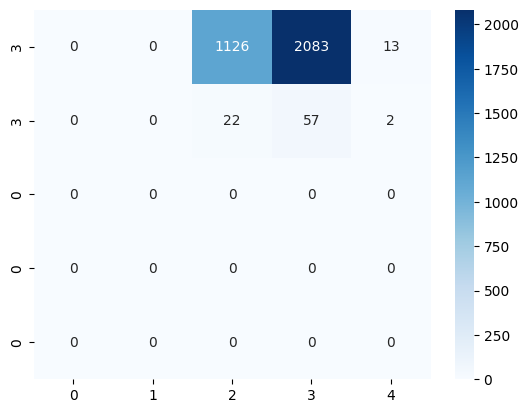

In [138]:
cm,ylabels = get_cm(y_train1,k_labels)